In [1]:
# importing necessary modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import datetime
import math
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sympy import S, symbols, printing

In [2]:
df = pd.read_csv('LA_singlestate_timeseries.csv')

# B.0. Pre-processing

In [3]:
# initiail look into data
df.head()

,date,country,state,county,fips,lat,long,locationId,actuals.cases,actuals.deaths,...,metrics.infectionRate,metrics.infectionRateCI90,metrics.icuHeadroomRatio,metrics.icuHeadroomDetails,metrics.icuCapacityRatio,riskLevels.overall,metrics.vaccinationsInitiatedRatio,metrics.vaccinationsCompletedRatio,actuals.newDeaths,actuals.vaccinesAdministered
0,2020-03-01,US,LA,NaN,22,NaN,NaN,iso1:us#iso2:us-la,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
1,2020-03-02,US,LA,NaN,22,NaN,NaN,iso1:us#iso2:us-la,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
2,2020-03-03,US,LA,NaN,22,NaN,NaN,iso1:us#iso2:us-la,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
3,2020-03-04,US,LA,NaN,22,NaN,NaN,iso1:us#iso2:us-la,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
4,2020-03-05,US,LA,NaN,22,NaN,NaN,iso1:us#iso2:us-la,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN


In [4]:
# because the dataset is coming from the same API, we need to do the same pre-processing 
# steps to ensure that all columns/features are of the appropriate data type.
# code is partially copy-pasted from part 1. 

new_df = df.copy()
# data is an object, but should be datetime for easy identification and filtration
new_df['date'] = pd.to_datetime(df['date'])
# We also have object - columns  whereas they should be either float or int.
# This is because  there is a string 'Not available' in them, making those objects by default.
# Not available can be replaced with np.nan which holds the same meaning and then column is converted to float.
new_df['actuals.contactTracers'] = df['actuals.contactTracers'].\
                                                            replace('Not available', np.nan).astype(float)
new_df['actuals.icuBeds.currentUsageCovid'] = df['actuals.icuBeds.currentUsageCovid'].\
                                                            replace('Not Available', np.nan).astype(float)
new_df['actuals.icuBeds.currentUsageCovid'] = df['actuals.icuBeds.currentUsageCovid'].\
                                                            replace('Not Available', np.nan).astype(float)

In [5]:
# preprocessed_df.dtypes # all good now. uncomment to see.

# B.1. Data analysis

## Task 1. 

There are two features present in the dataset that indicate cases: one is the *cumulative* number of cases, whereas the other is *new* daily cases.

Because we are looking into the association between cases and vaccination, I'd suggest using the cumulative cases for graphing, given that we expect flattening of the cases once vaccination begins, and cumulative cases can point straight away to this. We can perform *difference in means test* for *new*cases in the `period of vaccination` vs. `period of no vaccination` to further look into specific numeric metrics of the potential associated impact of the vaccine.

_Note: it is essential to mention that all the analyses performed here only indicate **correlation/associations**, and causality is not implied. For causality, further and more deep analyses such as synthetic controls or genetic matching need to be performed._

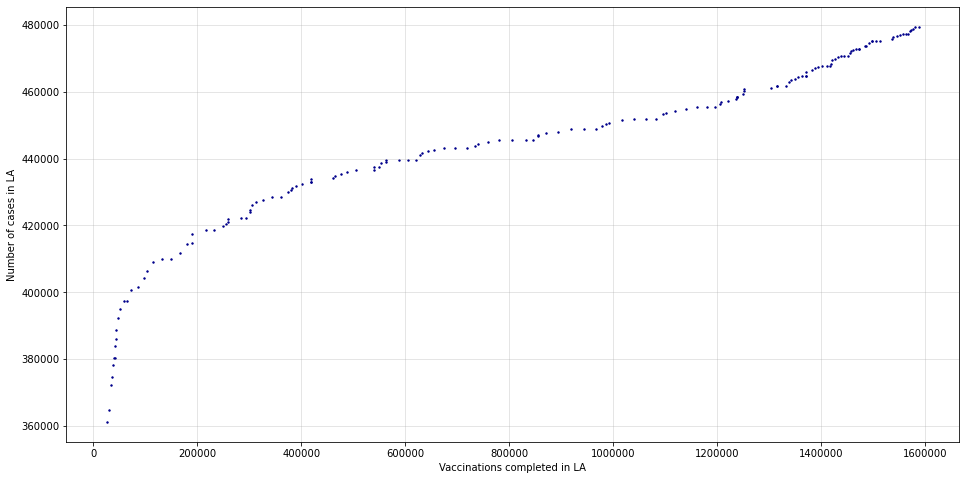

In [7]:
# quick plot
fig, ax = plt.subplots(figsize = (16,8))
ax.scatter(
    new_df['actuals.vaccinationsCompleted'],
    new_df['actuals.cases'], # new cases
    c='darkblue', 
    s=2
)
ax.grid(alpha=0.4)
ax.set_xlabel("Vaccinations completed in LA")
ax.set_ylabel("Number of cases in LA")
ax.ticklabel_format(useOffset=False, style='plain')

In [8]:
# lets check if we have any nulls. 
# this is important for any further analysis
print("Nulls in vaccinations:", new_df['actuals.vaccinationsCompleted'].isnull().sum(axis = 0))
print("Nulls in cases:", new_df['actuals.cases'].isnull().sum(axis = 0))

Nulls in vaccinations: 326
Nulls in cases: 11


As one can see, we have many nulls in the vaccination data. Let's see why we are having them.

Vaccinations started at : 2021-01-14 00:00:00


Text(0, 0.5, 'Presence of the null of actuals.vaccinationsCompleted')

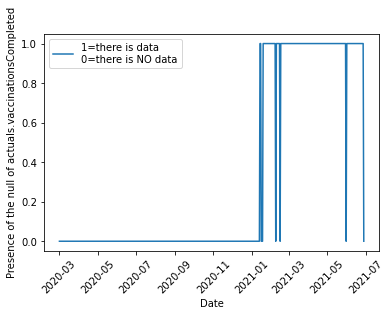

In [9]:
# let's see where the nulls in vaccinations are
import math
vacc_list = new_df['actuals.vaccinationsCompleted'].tolist()
vacc_list_bool = [None] * len(vacc_list) # storage list.
found_first_vacc = False # used to find the first date when first ever vaccine was actually administered
                           # in the region
for i in range(len(vacc_list)): 
    # we will bool True if there is data and False if there is not. 
    # the goal is to see some trend into why so much data is missing
    # so that we can better handle it
    vacc_list_bool[i] = False if math.isnan(vacc_list[i]) else True     
    if not found_first_vacc:  # used to find first day when vaccine was administered
        if not math.isnan(vacc_list[i]): 
            print('Vaccinations started at :', new_df['date'].tolist()[i])
            found_first_vacc = True
# let's vizualize this information for better comprehension
x_range = np.arange(0, len(vacc_list))
plt.plot(new_df['date'], vacc_list_bool, label = '1=there is data\n0=there is NO data')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.legend()
plt.ylabel('Presence of the null of actuals.vaccinationsCompleted')

By plotting missing data in the vaccinations column, one can see that *most of the nulls come from the pre-vaccination time,* meaning that we have **structurally missing data**. Contextually, this also means that there were simply no people getting the vaccine before the vaccine appeared, so we can **safely replace the nulls with 0 before the first date when vaccination started.**

In [10]:
# replace nulls with 0 before first vaccine date determined above
new_df['actuals.vaccinationsCompleted'] = new_df.apply(
    lambda row: 0 if np.isnan(row['actuals.vaccinationsCompleted']) and row['date'] < datetime.date(2021,1,14)
    else row['actuals.vaccinationsCompleted'],
    axis=1
)

With our change, we now see a significant drop in a number of nulls. There are a few nulls left which is an insignificant share of the whole dataset, which means that we can simply drop these rows with missing data to allow for further analysis.

In [11]:
df_wo_nulls = new_df[new_df['actuals.cases'].notna() & new_df['actuals.vaccinationsCompleted'].notna()]
# sanity check
print("Nulls in vaccinations:", df_wo_nulls['actuals.vaccinationsCompleted'].isnull().sum(axis = 0))
print("Nulls in cases:", df_wo_nulls['actuals.cases'].isnull().sum(axis = 0))

Nulls in vaccinations: 0
Nulls in cases: 0


With the task posed, my educated guess is that a  goal of this plotting is to see what potential associated impact the vaccinations had on the number of COVD cases. This raises two questions: 
1. Was the vaccine effective at lowering the number of cases? 
2. If so, how much?

These two questions will be answered using two different methods below.

### 1. Was the vaccine effective at lowering the number of cases? 

### Performing t-test to see whether there is a diference between new cases in time of vaccination versus no vaccination.

To answer the first question, I suggest doing a simple t-test as it is a fast and yet relatively reliable method. Again, this is not indicative of the causality and only would indicate any difference in the means. T-test works by stating the hypothesis and then trying to refute the null hypothesis. For our test, a $p-value < 0.005$ will suggest that the null hypothesis can be rejected in favor of the alternative hypothesis. 
- H0 (null hypothesis): there is no difference in the mean number of cases in the time of vaccination versus no time. 
- HA: there is the difference.

#### It is also important to double-check the assumptions for this method: 
1. Having continuous o ordinal scale in the data - ✅ 
2. Randomly selective & representative sample - ❌✅ The API provided doesn't provide too much quality information on whether this dataset includes all potential cases, even those that perhaps we're not reported from ie private clinics or 'home' professionals. Even though this is likely, I'd still argue that we probably have a reasonably representative sample.
3. Normal data distribution -  ❌✅ Because of the high amount of 0s, our distribution is skewed to the right.
**All in all, with the limited info we have, we can proceed with this partially accepted assumptions. If time permitted, we could also dig deeper into whether the assumptions are indeed met.**

In [14]:
from scipy.stats import ttest_ind
# remove na
df_wo_nulls2 = new_df[new_df['actuals.newCases'].notna()]
before_vacc = df_wo_nulls2[df_wo_nulls2['date'] < '2021-01-14']
after_vacc = df_wo_nulls2[df_wo_nulls2['date'] > '2021-01-14']
before_vacc = before_vacc.sample(n=after_vacc.shape[0])
print(before_vacc.shape, after_vacc.shape) # balancing two samples
ttest_ind(before_vacc['actuals.newCases'].values, after_vacc['actuals.newCases'].values,equal_var=True)

(162, 39) (162, 39)


Ttest_indResult(statistic=3.673394237929269, pvalue=0.00028020225878892357)

#### Lagging by 14 days
As it is widely known, the vaccine starts acting 14 days after the first dose. For example, Moderna becomes 50% effective against severe cases 2 weeks after the first dose. This is why we will perform another test below but with the lagged data.

In [15]:
before_vacc = df_wo_nulls2[df_wo_nulls2['date'] < '2021-01-29']
after_vacc = df_wo_nulls2[df_wo_nulls2['date'] > '2021-01-29']
before_vacc = before_vacc.sample(n=after_vacc.shape[0])
print(before_vacc.shape, after_vacc.shape)
ttest_ind(before_vacc['actuals.newCases'].values, after_vacc['actuals.newCases'].values,equal_var=True)

(147, 39) (147, 39)


Ttest_indResult(statistic=6.1022391621224195, pvalue=3.317521831128774e-09)

#### Result
As one can see, both tests have p-values lower than 0.05 (our previously defined threshold), which suggests that I should reject the null hypothesis. This concludes that the answer to question 1 is - *yes, the vaccine was likely effective.*

T-test also has its limitations, such a not looking into specific trends within the samples, such as those associated with the time trend. We will explore the time-associated trend below.

## 2. If so, how much?

To answer these questions, I will again use one of the simplest methods given the time limitations. We will drop the data when the vaccine was not yet in place to only study the effect and quality of its potential associated influence.

In [16]:
subset_df = df_wo_nulls[df_wo_nulls['date'] > '2021-01-14']

As a north star metric, I will use $R^2$, which is a widely accepted measure of fit. Our goal is to have it as high as possible. Also, we need to ensure that we dot over or under fit. For this, we will do a test-train split for the dataset.

In [18]:
X = subset_df['actuals.vaccinationsCompleted'].tolist()
y = subset_df['actuals.cases'].tolist()
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2)

for degree in range(1,5):
    p = np.polyfit(xtrain, ytrain, degree)
    mymodel = np.poly1d(p)
    myline = np.linspace(1, 1700000, 10000)

    print(f"\nFor the polynomial of degree {degree}, \nr^2 (TRAIN) is ", round(r2_score(ytrain, mymodel(xtrain)),4), 
         "r^2 (TEST) is ", round(r2_score(ytest, mymodel(xtest)), 4))

    print(p)    


For the polynomial of degree 1, 
r^2 (TRAIN) is  0.8964 r^2 (TEST) is  0.9295
[4.90161639e-02 4.01899602e+05]

For the polynomial of degree 2, 
r^2 (TRAIN) is  0.9324 r^2 (TEST) is  0.942
[-2.55790330e-08  9.04378591e-02  3.91963968e+05]

For the polynomial of degree 3, 
r^2 (TRAIN) is  0.9819 r^2 (TEST) is  0.983
[ 7.46716189e-14 -2.02670798e-07  1.99405140e-01  3.79344123e+05]

For the polynomial of degree 4, 
r^2 (TRAIN) is  0.9877 r^2 (TEST) is  0.9887
[-6.34960061e-20  2.77663166e-13 -4.09347236e-07  2.69987477e-01
  3.74474456e+05]


The values printed as arrays are the values of the coefficients in the equations. Also, by looking into this data, train and test $R^2$ do not have much divergence in their metrics, which signifies that there is no over or underfitting.

The polynmial of degree 4 is best-performing one as it maximizes R^2, which is a coefficient of dtermination. Given this, we can assume that the relationship is: 
$$ y =(-6.62994671e-20) x^4 + (2.87022748e-13) x^3 -(4.19007657e-07)x^2 + (2.72699586e-01) x+ 3.74629802e+05$$
where $y=cases$ and $x=vaccinations$ numbers.

It should be noted that the numbers are written with scientific notation.

### Let's plot this fit below.

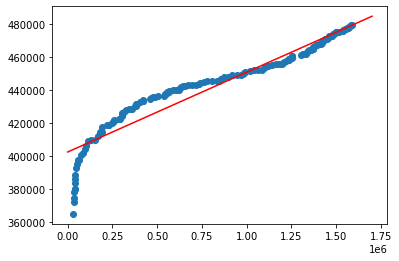

For the polynomial of degree 1, r^2 is  0.903725067763641


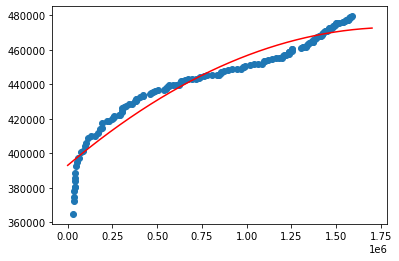

For the polynomial of degree 2, r^2 is  0.9349038755541806


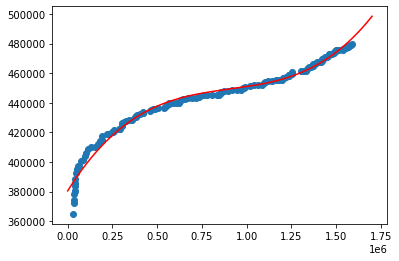

For the polynomial of degree 3, r^2 is  0.9823796035578045


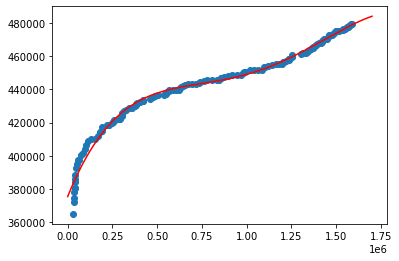

For the polynomial of degree 4, r^2 is  0.9880378634791457


In [19]:
X = subset_df['actuals.vaccinationsCompleted'].tolist()
y = subset_df['actuals.cases'].tolist()
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2)

for degree in range(1,5):
    mymodel = np.poly1d(np.polyfit(X, y, degree))
    myline = np.linspace(1, 1700000, 10000)
    plt.scatter(X, y)
    plt.plot(myline, mymodel(myline), color = 'red')
    plt.show()
    print(f"For the polynomial of degree {degree}, r^2 is ", r2_score(y, mymodel(X)))

## Task 2. 

(array([737485., 737546., 737607., 737669., 737730., 737791., 737850.,
        737911., 737972.]),
 <a list of 9 Text major ticklabel objects>)

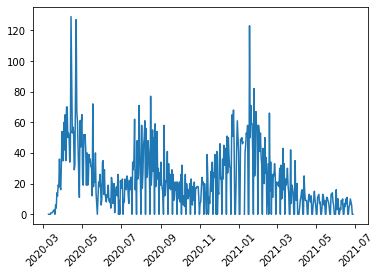

In [20]:
plt.plot(new_df['date'],new_df['actuals.newDeaths'])
plt.xticks(rotation = 45) 

As I am low at the time, I will explain what I would do in this task to better answer it: 
- Plot scatter plots between the studied variable and all other variables to see whether there is some apparent trend. 
- Form educated guesses/hypotheses a to what might be most indicative of the deaths. 
- From the initial look so far, it seems like the number of beds filled in is the most prominent feature associated with the studied measure.

So, in the ideal scenario in which I have a lot of time and computer power given, I'd run 
- (1) **random forest** with cross-validation to see what are the features determining the dependent variables the most. However, I could not run the script because of the combination of the high amount of nulls across the features and low computing power. 
- (2) **multiple linear regression**, which would allow seeing the associated impact (coefficient) and well as the p-value for the specific feature.

:(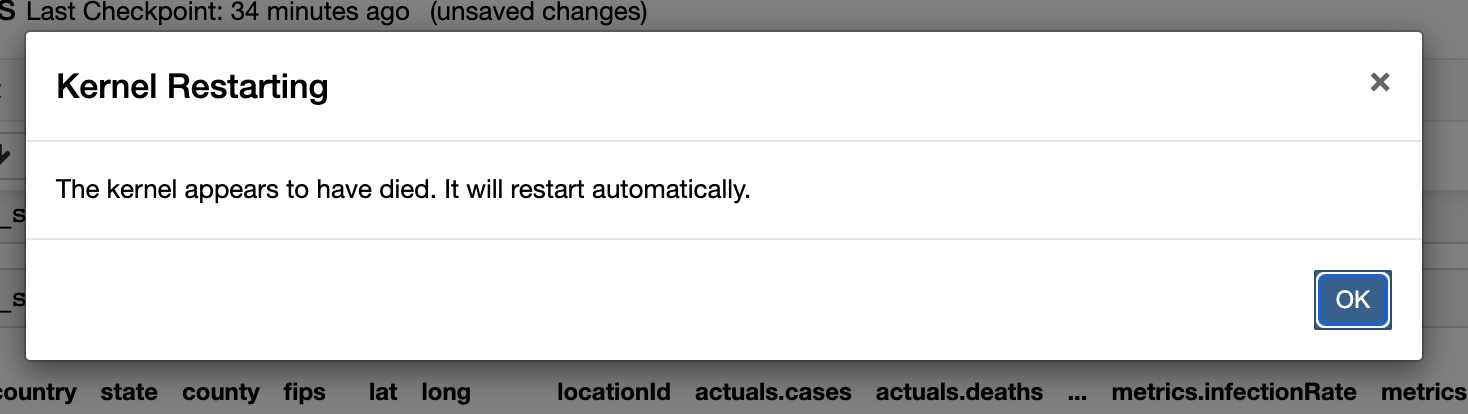

# Open Ended

## 3. Why do you think there is very limited data on hospital and ICU bed usage in Pennsylvania before mid-May 2020? Limit your answer to 1-2 sentences.


 Some of the likely reasons are: 
- (a) no data collection in the places themselves (end client problem); 
- (b) failure to report the data from the source (intermediary problem); 
- (c) data maintenance problem on our side (that is, we inputted wrong data in the first place that could not be corrected)
<br>

Out of all reasons, I'd check if all other states also have underreported data for that time and if so, then I'd suggest it is the reason (c). Otherwise, given how urgent the situation was at that time (COVID was just starting) and how unprepared the US was for it, it is likely that the reason is (a).

## 4. Given what you know about covid, refer to your time-series graph to explain which societal factors, if any, may have impacted the number of new covid deaths. Please hypothesize why you believe so. State any assumptions you have made. Limit your answer to no more than 2 paragraphs.

**Firstly, it must be said:**
1. All the conclusions drawn below are purely *inductive* and thus do not hold 100% certainty.
2. Generalizing to any levels (city > state, state > country) is not preferable. However, this is one of the only options that can be done to answer these questions as we only have sampled scientific papers and local observations recorded. 
**With this being said,**
- As one can see, there is fewer spikes & variation in the death counts in the beginning. The reason for this might be **inability to yet distinguish between COVID deaths vs. other-reason death.**
- At the end of the time range, one can see **how vaccinations administered affected the flattening of the curve**. Specifically, [even those rate of vaccination in LA is lower than average (47% got 1st dose by now)](https://covidactnow.org/us/louisiana-la/?s=21851111) it is still effective at preventing the most severe cases. Specifically, Moderna and Pfizer administered in LA are [79% and 97% effective against severe cases](https://informationisbeautiful.net/visualizations/covid-19-coronavirus-infographic-datapack/?mc_cid=678432a5bd&mc_eid=46909e490f#variants) which is a likely reason for the flattening in the end.
- Despite reinforcing a state-at-home order on [March 20](https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Louisiana), one can see that the highest number of deaths is reached after. This is due to (a) the fact that COVID hits with severe effects later on; (b) potential low trust towards governments. 
- The other societal factors affecting this could be: 
    - the 'toilet paper panic' which made thousands of people go to supermarkets simultaneously and thus affect the spread (as also suggested by [3blue1brown](https://www.youtube.com/watch?v=gxAaO2rsdIs))
    - the inability to adapt to the rapid change of lifestyle and continuation of usual life habits
    - disbelief & lack of trustability to governments. Especially at early stages, there was little known about COVID as a whole which only further reinforced questions and confusions that populations might have had, leading to more outings.

## 5. What are some possible limitations of this dataset? Limit your answer to 2-3 bullet points.

- **`county` and `long` `lat` data is not available**, making more localized & zoomed-in recommendations & dashboards for our client impossible. 
- there is minimal information available on **why there are missing data.** As a data scientist, I could only make educated guesses about whether the data is missing at random, not random, structured, or not. The type of missing data determines how it is handled, which might hugely affect the results if not handled and "guessed" correctly.
- while this dataset is being informative at some key data points on COVID, it is likely **to be not informative enough for our end client: there is little info on how businesses reopen and the governmental rules in place right now**. This could be solved by having another feature signifying the level of lockdown expressed as an integer.
- some of the **more static information,** such as capacities number of ICU & usual beds) are better to be further normalized with the help of relational databases. Even though it is likely to make data analysis more complex, it will better ensure strong consistency within the dataset, which is often crucial for many applications.

## 6. Briefly explain 1-2 recommendations you would relay to the team that maintains this dataset to overcome any of the limitations you mentioned above. Please keep your recommendations related to improving data quality, and not improving Louisiana's overall covid response. We are looking for how well you can explain and persuade through writing. Limit your answer to no more than 2-3 sentences.

Assuming that someone who is maintaining this dataset is technical (ie, Database Engineer), I'd like to say:

_Thank you for maintaining this database so far. Your work has been crucial in determining the safety of the American people and beyond, and its value cannot be overappreciated._

_With this being said, I'd like to suggest two improvements that can be done to make maintenance *easier and yet more accurate*._


_First, many of the columns lack data altogether. Even though the number of cases, deaths, and vaccinations is reported, other features like ICU beds and usual hospital capacity are not as much. Given that at least millions of people likely use your site and API for various purposes, it is essential to maintain these data points. I understand the potential extra effort needed and the tradeoff between quality and quantity; therefore, it might be preferable to roll out a quick user research survey to determine the most frequent users of the dataset and then accommodate their needs accordingly._


_Second, given that a lot of the data is static (meaning, same feature value for ie. all states, or all counties, many days, and doesn't change too often), I suggest normalizing data by refactoring the database into relational database (ie MySQL) which would allow for fewer repetitions with the data. To make an example concrete, I am talking about ie, hospital capacity, which is likely to stay the same for weeks. This data could be stored separately in the DB in which the start and end date of the specific measurements are recorded. The tradeoff brought here is higher maintenance cost which also might influence data analysis data retrieval. However, for the dataset of such importance, maintaining high accuracy & consistency should be the top priority._

_I  will be happy to explain, clarify, and discuss any of the points above. Curious to hear what you think too!_


# What would I improve if I had more time?
- I would run random forest and multiple regression in task 2, part 2. 


# Thank you!